<a href="https://colab.research.google.com/github/Nazhan99/Tensorflow_notes/blob/main/06_transfer_learning_in_tensorflow_part_3_scaling_up.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Transfer Learning with TensorFlow Part 3: Scaling Up (Food Vision Mini)

we have done transfer learning feature extraction and fine-tuning, now it is the time to scale up too all of the classes in Food101 (101 total classes of food).

Our goal is to beat the original Food101 paper with 10% of the training (leveraging the power of deep learning).

Original food101 paper: https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/static/bossard_eccv14_food-101.pdf

Our baseline to beat is 50.76% accuracy across 101 classes.

In [1]:
#check to see if we are using GPU
!nvidia-smi

Sun Feb 27 03:33:07 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P8    24W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
## creating helper functions

!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2022-02-27 03:33:08--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-02-27 03:33:08 (61.2 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [3]:
#import series of helper functions for our notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir

## 101 Food classes: working with less data

The data comes from the original food 101 dataset but has been preprocess using image _data_modification

In [4]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
unzip_data("101_food_classes_10_percent.zip")

--2022-02-27 03:33:11--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 209.85.147.128, 142.250.125.128, 142.250.136.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|209.85.147.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip’

101_food_classes_10 100%[===================>]   1.51G   101MB/s    in 14s     

2022-02-27 03:33:26 (108 MB/s) - ‘101_food_classes_10_percent.zip’ saved [1625420029/1625420029]



In [5]:
train_dir="101_food_classes_10_percent/train/"
test_dir="101_food_classes_10_percent/test/"

In [6]:
#how many images/classes are there?
walk_through_dir("101_food_classes_10_percent")

There are 2 directories and 0 images in '101_food_classes_10_percent'.
There are 101 directories and 0 images in '101_food_classes_10_percent/test'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/tiramisu'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/cannoli'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/strawberry_shortcake'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/chocolate_mousse'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/lobster_bisque'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/frozen_yogurt'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/fried_rice'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/prime_rib'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/pho'.
There are 0 directories and 250 images i

In [7]:
#setup data inputs
import tensorflow as tf
IMG_SIZE=(224,224)
train_data_all_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                                image_size=IMG_SIZE,
                                                                                label_mode="categorical")

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE,
                                                                shuffle=False) #dont shuffle test data for prediction analysis

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


## Train a big dog model with transfer learning on 10% of 101 food classes

Here are the steps we are going to take:

* Create a ModelCheckpoint callback
* Create a data augmentation layer to build data augmentation right into the model
* Build a headless (no top layers) Functional EfficeintNetB0 backboned-model ( we will create our own output layer)
* compile our model
* Feature extract for 5 full passes (5 epochs on the train dataset and validate on 15% of the test data, to save epoch time)

In [8]:
# create checkpoint callback
checkpoint_path="101_classes_10_percent_data_model_checkpoint"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                         save_weights=True,
                                                         monitor="val_accuracy",
                                                         save_best_only=True)

In [9]:
#create data augmentation layer to incorporate it right into the model
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

#setup data augmentation
data_augmentation =Sequential([
                               layers.RandomFlip("horizontal"),
                               layers.RandomRotation(0.2),
                               layers.RandomHeight(0.2),
                               layers.RandomWidth(0.2),
                               layers.RandomZoom(0.2),
                               #layers.Rescaling(1/./255) # rescale input of images to between 0 & 1 reqquired for resnet model
], name="data_augmentation")



In [10]:
# Setup the base model and freeze its layers (this will extract features)
base_model = tf.keras.applications.EfficientNetB0(include_top = False)
base_model.trainable = False

#Setup model architecture with trainable top layers
inputs = layers.Input(shape=(224,224,3), name="input_layer")
x = data_augmentation(inputs) #augment images (only happens during training phase)
x = base_model(x, training=False) #put the base model in inference mode so weight which need to stay frozen will stay frozen
x = layers.GlobalAveragePooling2D(name="global_avg_pool_layer")(x)
outputs = layers.Dense(len(train_data_all_10_percent.class_names), activation="softmax", name="output_layer")(x)

model = tf.keras.Model(inputs, outputs)

16719872/16705208 [==============================] - 0s 0us/step


In [11]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, 224, 224, 3)      0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_avg_pool_layer (Glob  (None, 1280)             0         
 alAveragePooling2D)                                             
                                                                 
 output_layer (Dense)        (None, 101)               129381    
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-trainab

In [12]:
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(learning_rate= 0.0001),
              metrics=["accuracy"])

history_all_classes_10_percent = model.fit(train_data_all_10_percent,
                                            epochs=5, #fit for 5 epochs to this experiment
                                            validation_data=test_data,
                                            validation_steps=int(0.15*len(test_data)), #validate  on only 15% of test data
                                            callbacks=[checkpoint_callback])

Epoch 1/5
237/237 [==============================] - 183s 695ms/step - loss: 4.4853 - accuracy: 0.0424 - val_loss: 4.3897 - val_accuracy: 0.0474
Epoch 2/5
237/237 [==============================] - 145s 610ms/step - loss: 4.0835 - accuracy: 0.1542 - val_loss: 4.0487 - val_accuracy: 0.1287
Epoch 3/5
237/237 [==============================] - 133s 560ms/step - loss: 3.7496 - accuracy: 0.2525 - val_loss: 3.7769 - val_accuracy: 0.1970
Epoch 4/5
237/237 [==============================] - 128s 537ms/step - loss: 3.4874 - accuracy: 0.3129 - val_loss: 3.5407 - val_accuracy: 0.2574
Epoch 5/5
237/237 [==============================] - 125s 526ms/step - loss: 3.2626 - accuracy: 0.3525 - val_loss: 3.3464 - val_accuracy: 0.2966


In [13]:
#Evaluate on the whole test dataset
feature_extraction_results = model.evaluate(test_data)
feature_extraction_results

790/790 [==============================] - 102s 129ms/step - loss: 3.0660 - accuracy: 0.3923


[3.06597900390625, 0.39227724075317383]

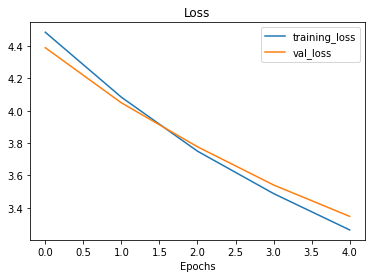

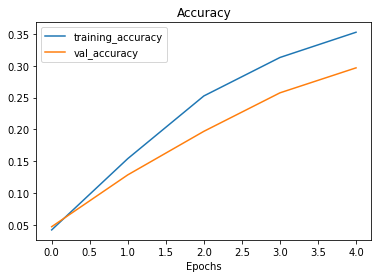

In [14]:
plot_loss_curves(history_all_classes_10_percent)

## Fine Tuning

In [15]:
#Unfreeze all of the layers in the base model
base_model.trainable = True

#Refreeze every layer except the last 5
for layer in base_model.layers[:-5]:
  layer.trainable = False

In [16]:
#recompile model 
model.compile(loss="categorical_crossentropy",
              optimizer= tf.keras.optimizers.Adam(learning_rate = 0.0001),
              metrics=["accuracy"])

In [17]:
#what layers in the model are trainble?
for layer in model.layers:
  print(layer.name, layer.trainable)

input_layer True
data_augmentation True
efficientnetb0 True
global_avg_pool_layer True
output_layer True


In [18]:
#check which layers are trainable in our base model
for layer_number, layer in enumerate(model.layers[2].layers):
  print(layer_number, layer.name, layer.trainable)

0 input_1 False
1 rescaling False
2 normalization False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_reshape F

In [19]:
#Fine-tune for 5 more epochs
fine_tune_epochs = 10  #model has already  done 5 epochs (feature extraction), this is the total number of epochs after (5 epochs)

#Fine-tune our model
history_all_classes_10_percent_fine_tune = model.fit(train_data_all_10_percent,
                                                     epochs=fine_tune_epochs,
                                                     validation_data=test_data,
                                                     validation_steps=int(0.15*len(test_data)),
                                                     initial_epoch=history_all_classes_10_percent.epoch[-1])

Epoch 5/10
237/237 [==============================] - 85s 319ms/step - loss: 2.5520 - accuracy: 0.4044 - val_loss: 2.3480 - val_accuracy: 0.4134
Epoch 6/10
237/237 [==============================] - 70s 295ms/step - loss: 2.1108 - accuracy: 0.4714 - val_loss: 2.2022 - val_accuracy: 0.4349
Epoch 7/10
237/237 [==============================] - 68s 285ms/step - loss: 1.9247 - accuracy: 0.5106 - val_loss: 2.1011 - val_accuracy: 0.4552
Epoch 8/10
237/237 [==============================] - 64s 267ms/step - loss: 1.8045 - accuracy: 0.5391 - val_loss: 2.0128 - val_accuracy: 0.4733
Epoch 9/10
237/237 [==============================] - 68s 283ms/step - loss: 1.6859 - accuracy: 0.5653 - val_loss: 1.9876 - val_accuracy: 0.4730
Epoch 10/10
237/237 [==============================] - 64s 267ms/step - loss: 1.5985 - accuracy: 0.5843 - val_loss: 1.9751 - val_accuracy: 0.4793


In [20]:
#Evaluate on the whole test data
all_classes_10_percent_fine_tune_results = model.evaluate(test_data)
all_classes_10_percent_fine_tune_results

790/790 [==============================] - 102s 128ms/step - loss: 1.7232 - accuracy: 0.5388


[1.723174810409546, 0.5388118624687195]

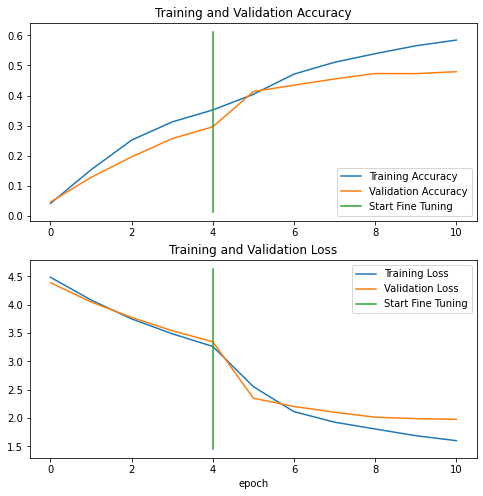

In [21]:
#compare histories of feature extraction
compare_historys(original_history=history_all_classes_10_percent,
                 new_history=history_all_classes_10_percent_fine_tune,
                 initial_epochs=5)

## Saving and loading our model

To use our model in an external application, we will need to save it and export it somewhere.

In [22]:
#Save our fine-tunign model
model.save("drive/MyDrive/tensorflow_course/101_food_classes_10_percent_saved_big_dog_model")

INFO:tensorflow:Assets written to: drive/MyDrive/tensorflow_course/101_food_classes_10_percent_saved_big_dog_model/assets


In [23]:
#Load an evaluate saved model
loaded_model=tf.keras.models.load_model("drive/MyDrive/tensorflow_course/101_food_classes_10_percent_saved_big_dog_model")

In [24]:
#evaluate loaded model and compare performance to pre saved model
loaded_model_results = loaded_model.evaluate(test_data)
loaded_model_results

790/790 [==============================] - 105s 130ms/step - loss: 1.7232 - accuracy: 0.5388


[1.723174810409546, 0.5388118624687195]

The load model result should be the same as pre saved model (all_classes_10_percent_fine_tune_results)

# Evaluating th eperformance of the big dog model across all different classes

Let's make some predictions, visualize them and then later find out which predictions were the "most" wrong.

In [25]:
import tensorflow as tf

!wget https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip

--2022-02-27 04:01:42--  https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.194.128, 173.194.196.128, 173.194.197.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.194.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 46760742 (45M) [application/zip]
Saving to: ‘06_101_food_class_10_percent_saved_big_dog_model.zip’

06_101_food_class_1 100%[===================>]  44.59M   143MB/s    in 0.3s    

2022-02-27 04:01:42 (143 MB/s) - ‘06_101_food_class_10_percent_saved_big_dog_model.zip’ saved [46760742/46760742]



In [26]:
unzip_data("06_101_food_class_10_percent_saved_big_dog_model.zip")

In [27]:
#load in pre saved model
model = tf.keras.models.load_model("06_101_food_class_10_percent_saved_big_dog_model")

In [28]:
# Evaluate loaded model
results_downloaded_model = model.evaluate(test_data)
results_downloaded_model

790/790 [==============================] - 104s 130ms/step - loss: 1.8027 - accuracy: 0.6078


[1.8027207851409912, 0.6077623963356018]

# Make predictions with our trained model

In [29]:
# Make prediction with model
preds_probs = model.predict(test_data, verbose=1) #set verbosity to see how long is left

790/790 [==============================] - 98s 121ms/step


In [30]:
#how many predictions are there?
len(preds_probs)

25250

In [31]:
# what is the shape of our predictions?
preds_probs.shape

(25250, 101)

In [32]:
# Let's see what the first 10 predictions look like
preds_probs[:10]

array([[5.9541941e-02, 3.5742332e-06, 4.1376889e-02, ..., 1.4138899e-09,
        8.3530460e-05, 3.0897565e-03],
       [9.6401680e-01, 1.3753089e-09, 8.4779976e-04, ..., 5.4286684e-05,
        7.8363253e-12, 9.8467334e-10],
       [9.5925868e-01, 3.2534019e-05, 1.4867033e-03, ..., 7.1891884e-07,
        5.4398350e-07, 4.0276311e-05],
       ...,
       [4.7313324e-01, 1.2931301e-07, 1.4805583e-03, ..., 5.9749611e-04,
        6.6969820e-05, 2.3469329e-05],
       [4.4571780e-02, 4.7265351e-07, 1.2258515e-01, ..., 6.3498578e-06,
        7.5319103e-06, 3.6778715e-03],
       [7.2438985e-01, 1.9249777e-09, 5.2310857e-05, ..., 1.2291447e-03,
        1.5793171e-09, 9.6395503e-05]], dtype=float32)

In [33]:
# what does the first prediction probability array look like
preds_probs[0], len(preds_probs[0]), sum(preds_probs[0])

(array([5.9541941e-02, 3.5742332e-06, 4.1376889e-02, 1.0660903e-09,
        8.1613996e-09, 8.6639682e-09, 8.0926134e-07, 8.5652442e-07,
        1.9858850e-05, 8.0977554e-07, 3.1727692e-09, 9.8673388e-07,
        2.8532100e-04, 7.8049661e-10, 7.4230990e-04, 3.8915794e-05,
        6.4740016e-06, 2.4977169e-06, 3.7891397e-05, 2.0678806e-07,
        1.5538471e-05, 8.1506892e-07, 2.6230925e-06, 2.0010653e-07,
        8.3827712e-07, 5.4215743e-06, 3.7391112e-06, 1.3150788e-08,
        2.7761345e-03, 2.8051816e-05, 6.8561651e-10, 2.5574524e-05,
        1.6688934e-04, 7.6409645e-10, 4.0452869e-04, 1.3150487e-08,
        1.7957433e-06, 1.4448400e-06, 2.3062853e-02, 8.2465459e-07,
        8.5366531e-07, 1.7138503e-06, 7.0526130e-06, 1.8402382e-08,
        2.8553984e-07, 7.9482870e-06, 2.0682012e-06, 1.8525193e-07,
        3.3619781e-08, 3.1522335e-04, 1.0410886e-05, 8.5448306e-07,
        8.4741890e-01, 1.0555387e-05, 4.4094719e-07, 3.7404192e-05,
        3.5306137e-05, 3.2489079e-05, 6.7313988e

Our model outputs a prediction probability array (with N number of variable where N is the number of classes) for each sample passed to the predict method.

In [34]:
# We get one prediction probability per class (in our case there is 101 prediction probablity)
print(f"Number of prediction probabilities for sampe 0: {len(preds_probs[0])}")
print(f"What prediction probability sample 0 looks like: \n {preds_probs[0]}")
print(f"The class with the highest predicted probability by the model for sample 0: {preds_probs[0].argmax()}")

Number of prediction probabilities for sampe 0: 101
What prediction probability sample 0 looks like: 
 [5.9541941e-02 3.5742332e-06 4.1376889e-02 1.0660903e-09 8.1613996e-09
 8.6639682e-09 8.0926134e-07 8.5652442e-07 1.9858850e-05 8.0977554e-07
 3.1727692e-09 9.8673388e-07 2.8532100e-04 7.8049661e-10 7.4230990e-04
 3.8915794e-05 6.4740016e-06 2.4977169e-06 3.7891397e-05 2.0678806e-07
 1.5538471e-05 8.1506892e-07 2.6230925e-06 2.0010653e-07 8.3827712e-07
 5.4215743e-06 3.7391112e-06 1.3150788e-08 2.7761345e-03 2.8051816e-05
 6.8561651e-10 2.5574524e-05 1.6688934e-04 7.6409645e-10 4.0452869e-04
 1.3150487e-08 1.7957433e-06 1.4448400e-06 2.3062853e-02 8.2465459e-07
 8.5366531e-07 1.7138503e-06 7.0526130e-06 1.8402382e-08 2.8553984e-07
 7.9482870e-06 2.0682012e-06 1.8525193e-07 3.3619781e-08 3.1522335e-04
 1.0410886e-05 8.5448306e-07 8.4741890e-01 1.0555387e-05 4.4094719e-07
 3.7404192e-05 3.5306137e-05 3.2489079e-05 6.7313988e-05 1.2852399e-08
 2.6220215e-10 1.0318094e-05 8.5742751e-05 1.

In [35]:
test_data.class_names[52]

'gyoza'

In [36]:
#get the pred classes of each label
pred_classes = preds_probs.argmax(axis=1)

#how do they look?
pred_classes[:10]

array([52,  0,  0, 80, 79, 61, 29,  0, 85,  0])

In [37]:
#how many pred classes do we have?
len(pred_classes)

25250

Now we got our prediction array of all our model's predictions, to evaluate them, we need to compare the original labels.

In [38]:
# to get our test labels we need to unravel our test_data BatchDataset
y_labels = []
for images, labels in test_data.unbatch():
  y_labels.append(labels.numpy().argmax()) #currently test labels look like  [ 0,0,0,1, .... 0,0], we want index value when 1 occurs.
y_labels[:10] #look at the first 10

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [39]:
#how many y labels are there?
len(y_labels)

25250

## Evaluating our model's predictions

One way to check that our model's predictions array is in the same order as our test labels array is to find the accuracy score.

In [40]:
results_downloaded_model

[1.8027207851409912, 0.6077623963356018]

In [41]:
#let's try scikit-learn's accuracy score function and see what it comes up with
from sklearn.metrics import accuracy_score
sklearn_accuracy = accuracy_score(y_true= y_labels,
                                  y_pred = pred_classes)

sklearn_accuracy

0.6077623762376237

In [42]:
# does this metric comes close to our model's evaluate results
import numpy as np
np.isclose(results_downloaded_model[1], sklearn_accuracy)

True

# Let's get visual: making a confusion matrix

In [43]:
from helper_functions import make_confusion_matrix

In [44]:
#get a list of class_names
class_names = test_data.class_names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [45]:
# we need to changes to our make_confusion_matrix function to ensure the x-labels print vertically

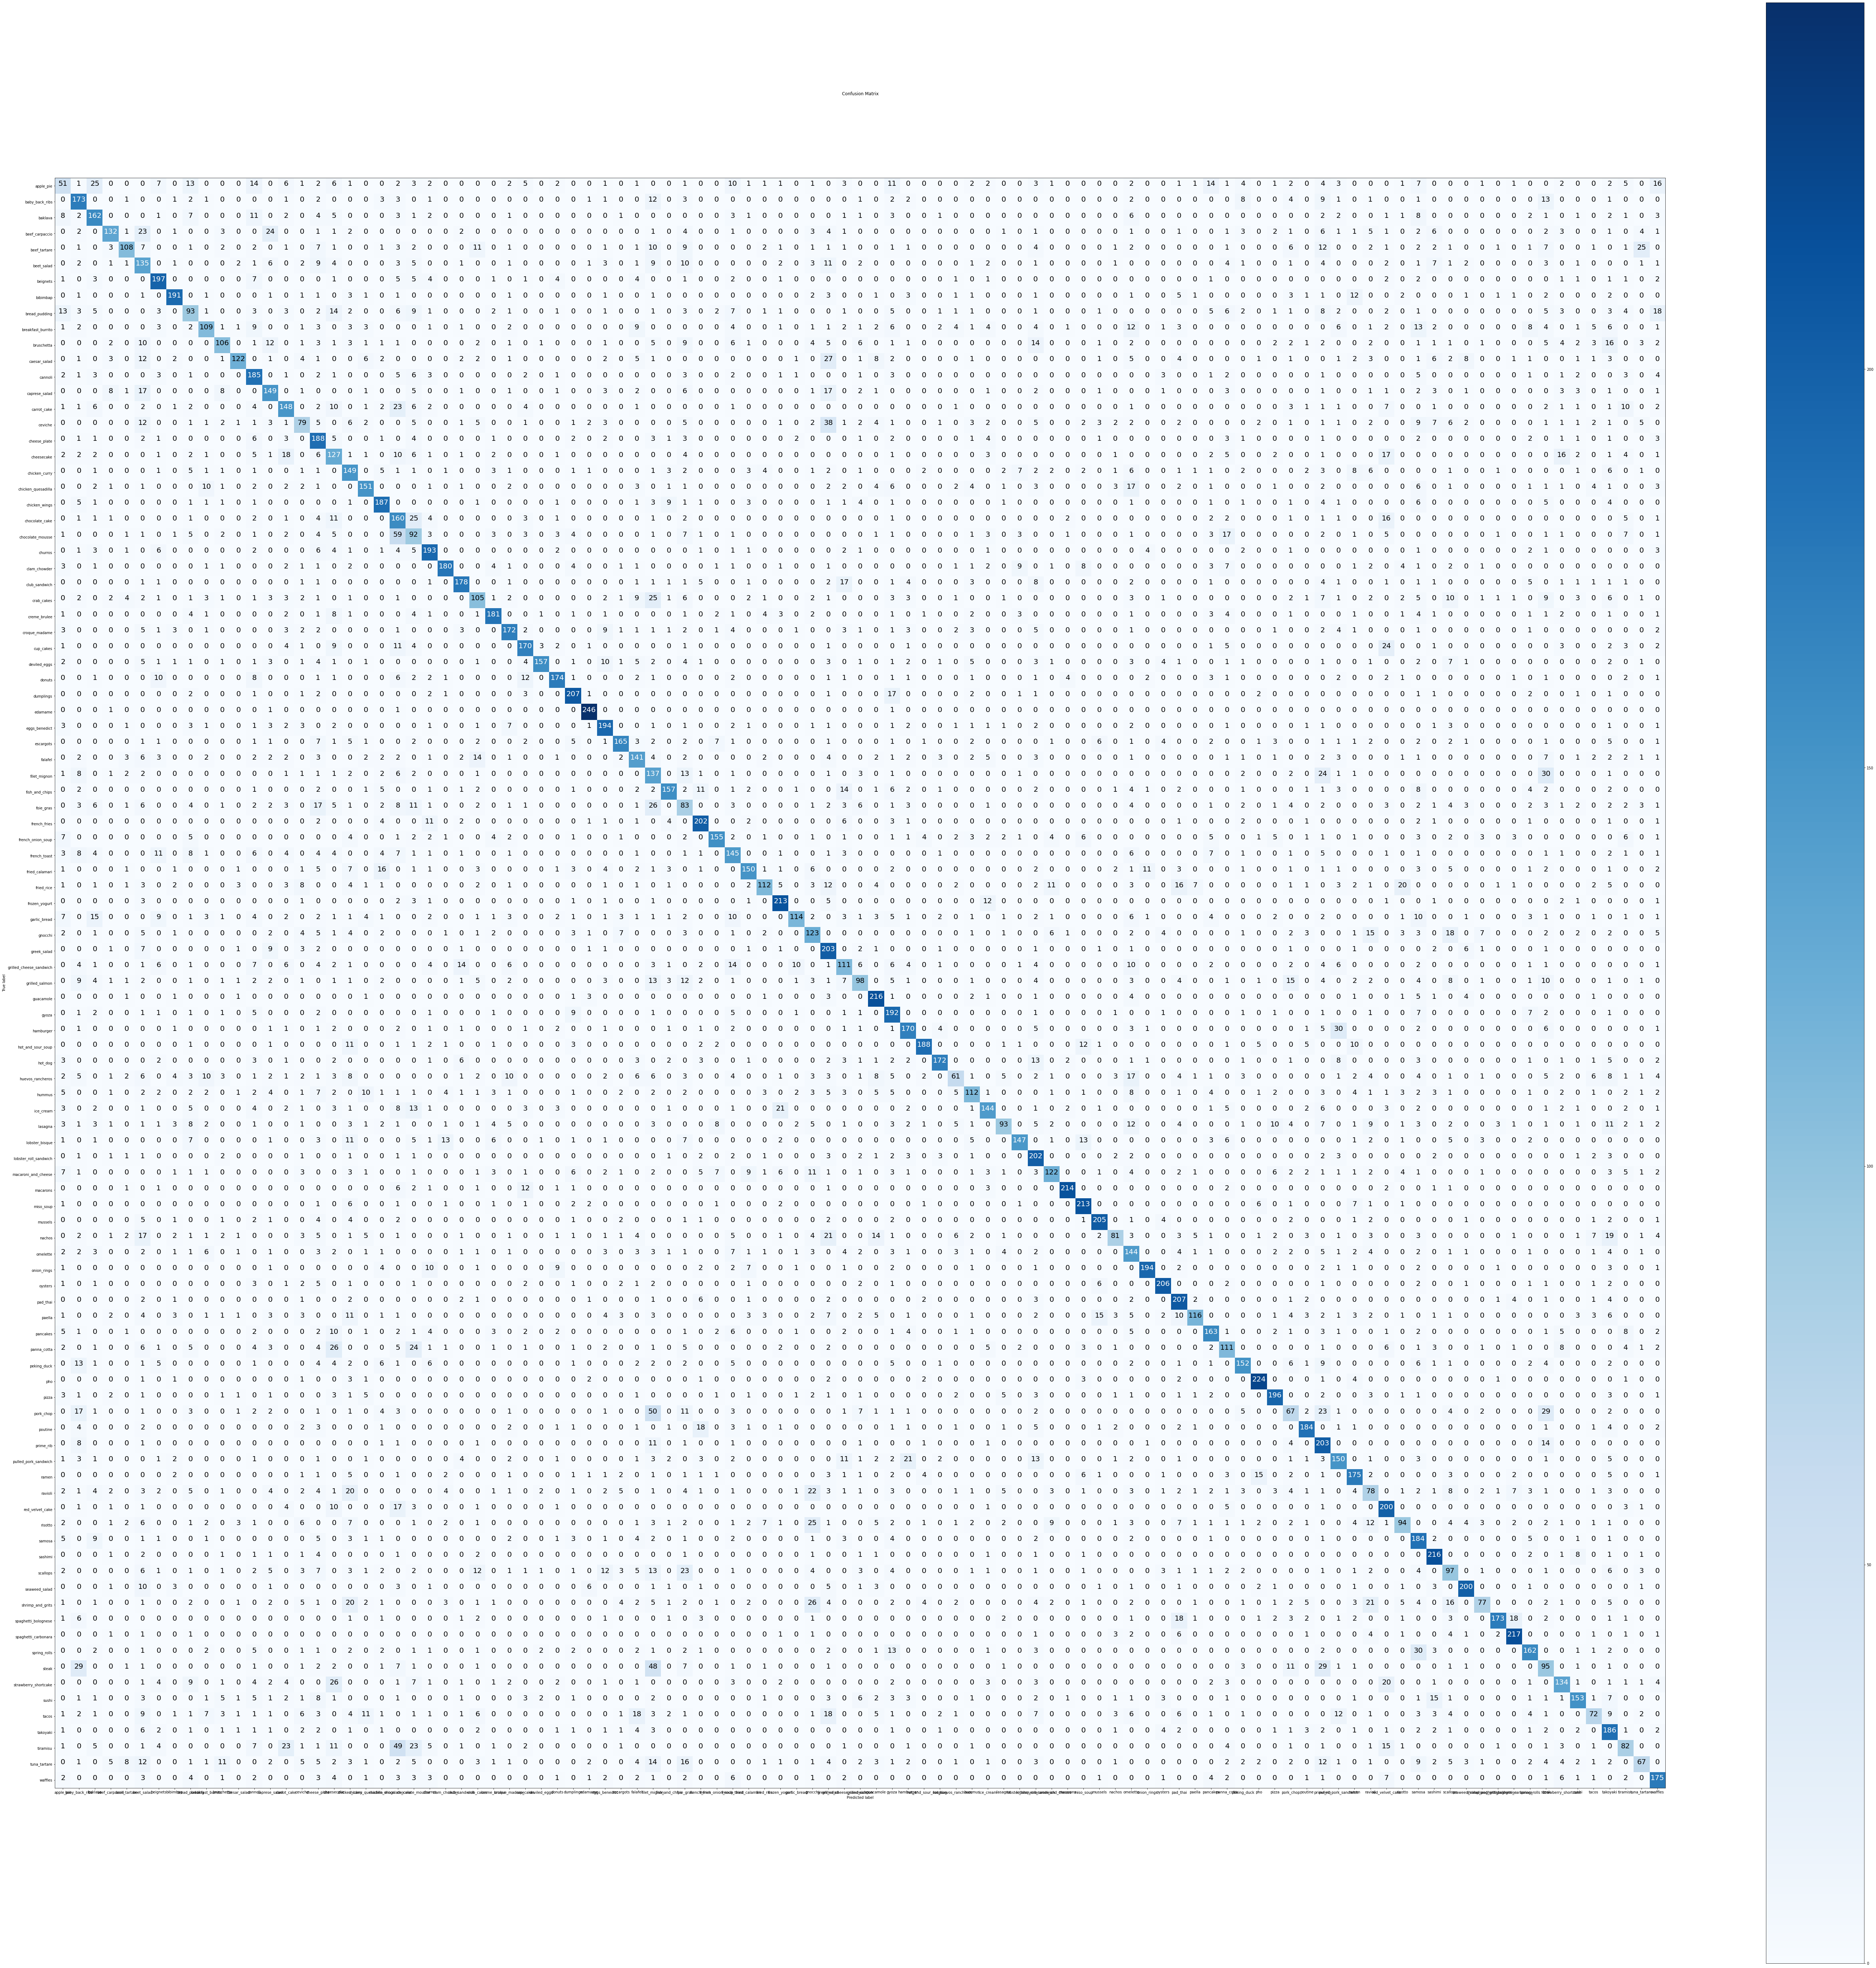

In [46]:
make_confusion_matrix(y_true = y_labels,
                      y_pred = pred_classes,
                      classes = class_names,
                      figsize = (100,100),
                      text_size = 20)

In [47]:
import itertools
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# Our function needs a different name to sklearn's plot_confusion_matrix
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False): 
  """Makes a labelled confusion matrix comparing predictions and ground truth labels.
  If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.
  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
    norm: normalize values or not (default=False).
    savefig: save confusion matrix to file (default=False).
  
  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.
  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
  """  
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])
  
  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes), 
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)
  
  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  ## Changed (plot xlabels verically)##
  plt.xticks(rotation=70, fontsize = text_size)
  plt.yticks(fontsize=text_size)

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
  if savefig:
    fig.savefig("confusion_matrix.png")

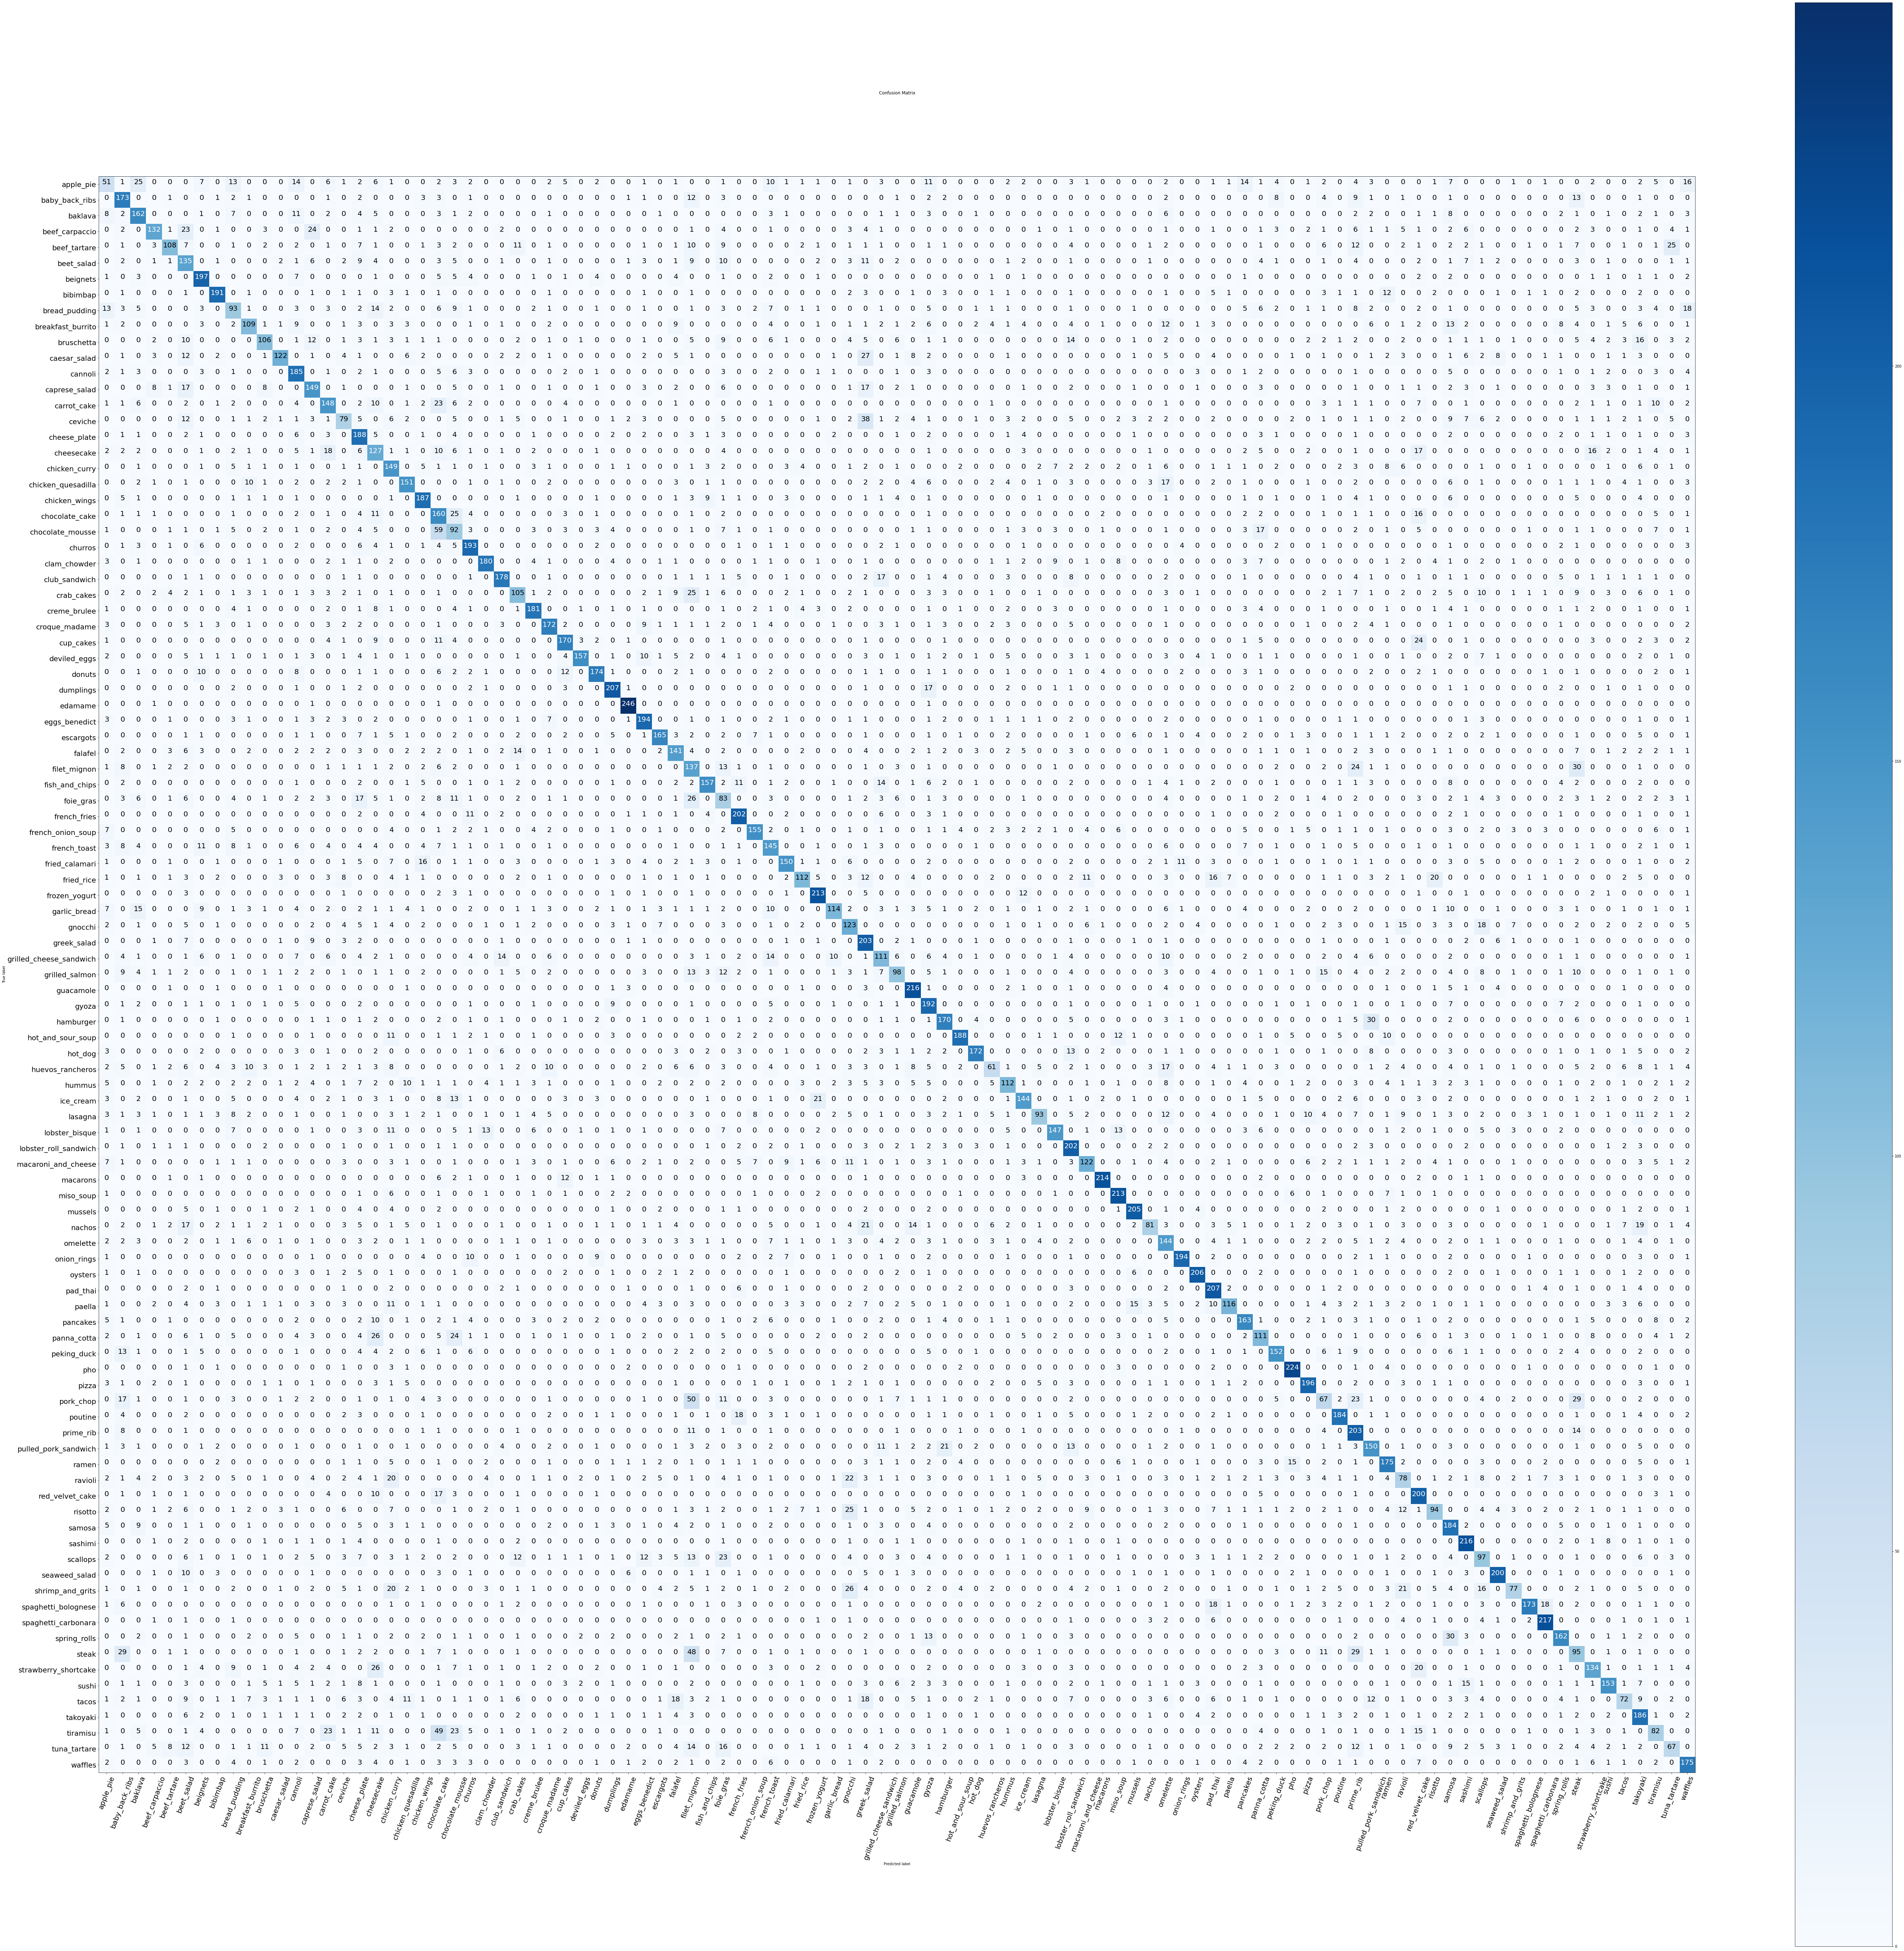

In [48]:
make_confusion_matrix(y_true = y_labels,
                      y_pred = pred_classes,
                      classes = class_names,
                      figsize = (100,100),
                      text_size = 20,
                      savefig = True)

## Let's keep the evaluation train going, time for a classification report

In [49]:
from sklearn.metrics import classification_report
print(classification_report(y_true = y_labels,
                            y_pred = pred_classes))

              precision    recall  f1-score   support

           0       0.29      0.20      0.24       250
           1       0.51      0.69      0.59       250
           2       0.56      0.65      0.60       250
           3       0.74      0.53      0.62       250
           4       0.73      0.43      0.54       250
           5       0.34      0.54      0.42       250
           6       0.67      0.79      0.72       250
           7       0.82      0.76      0.79       250
           8       0.40      0.37      0.39       250
           9       0.62      0.44      0.51       250
          10       0.62      0.42      0.50       250
          11       0.84      0.49      0.62       250
          12       0.52      0.74      0.61       250
          13       0.56      0.60      0.58       250
          14       0.56      0.59      0.57       250
          15       0.44      0.32      0.37       250
          16       0.45      0.75      0.57       250
          17       0.37    

In [50]:
# Get a dictionary of the classification report
classification_report_dict = classification_report( y_labels, pred_classes, output_dict=True)
#classification_report_dict

Let's plot all of our classes F1-scores

In [51]:
classification_report_dict["99"]["f1-score"]

0.35356200527704484

In [52]:
#create empty dictionary
class_f1_score = {}

#loop through classification report dictionary items
for k, v in classification_report_dict.items():
  if k == "accuracy": #stop once we get to accuracy key
    break
  else:
    #add class names and f1-scores to new dictionary
    class_f1_score[class_names[int(k)]] = v["f1-score"]

class_f1_score


{'apple_pie': 0.24056603773584903,
 'baby_back_ribs': 0.5864406779661017,
 'baklava': 0.6022304832713754,
 'beef_carpaccio': 0.616822429906542,
 'beef_tartare': 0.544080604534005,
 'beet_salad': 0.41860465116279066,
 'beignets': 0.7229357798165138,
 'bibimbap': 0.7908902691511386,
 'bread_pudding': 0.3866943866943867,
 'breakfast_burrito': 0.5117370892018779,
 'bruschetta': 0.5047619047619047,
 'caesar_salad': 0.6161616161616161,
 'cannoli': 0.6105610561056106,
 'caprese_salad': 0.5775193798449612,
 'carrot_cake': 0.574757281553398,
 'ceviche': 0.36744186046511623,
 'cheese_plate': 0.5654135338345864,
 'cheesecake': 0.42546063651591287,
 'chicken_curry': 0.5008403361344538,
 'chicken_quesadilla': 0.6411889596602972,
 'chicken_wings': 0.7123809523809523,
 'chocolate_cake': 0.45261669024045265,
 'chocolate_mousse': 0.3291592128801431,
 'churros': 0.7134935304990757,
 'clam_chowder': 0.7708779443254817,
 'club_sandwich': 0.734020618556701,
 'crab_cakes': 0.4625550660792952,
 'creme_brulee

In [53]:
#Trun f1-scores into dataframe for visualization
import pandas as pd
f1_scores = pd.DataFrame({"class_names": list(class_f1_score.keys()),
                          "f1-score": list(class_f1_score.values())}).sort_values("f1-score", ascending=False)
                   

In [54]:
f1_scores

class_names  f1-score
33              edamame  0.937143
63             macarons  0.895397
75                  pho  0.866538
91  spaghetti_carbonara  0.847656
69              oysters  0.834008
..                  ...       ...
56     huevos_rancheros  0.339833
22     chocolate_mousse  0.329159
77            pork_chop  0.308756
39            foie_gras  0.297491
0             apple_pie  0.240566

[101 rows x 2 columns]

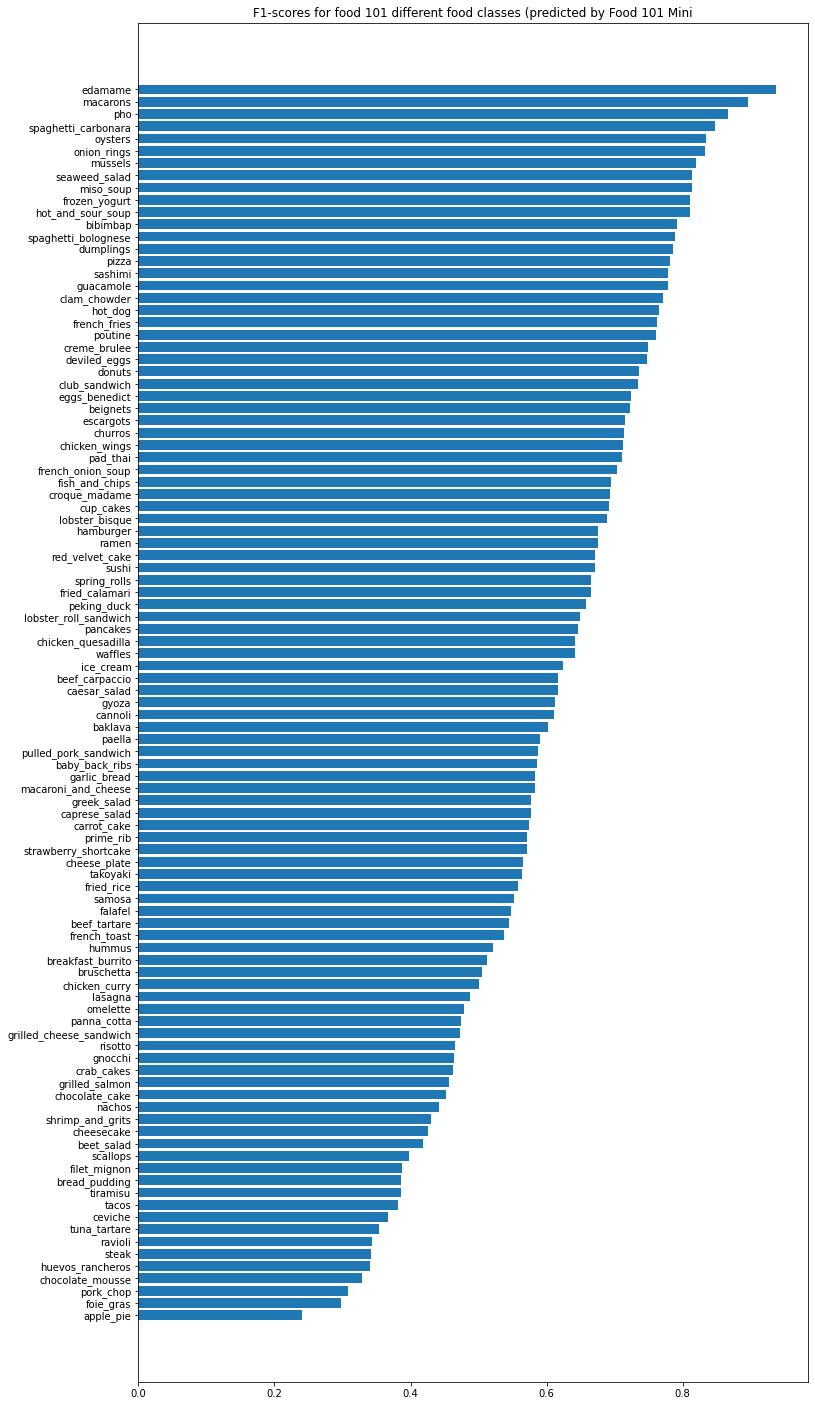

In [55]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize = (12,25))
scores = ax.barh(range(len(f1_scores)), f1_scores["f1-score"].values) #get f1-score values
ax.set_yticks(range(len(f1_scores)))
ax.set_yticklabels(f1_scores["class_names"])
ax.set_title("F1-scores for food 101 different food classes (predicted by Food 101 Mini")
ax.invert_yaxis(); #reverse the order of our plot

## Visualizing predictions on custom images

Now, this is the real test, how does our model go on food images not even in our test dataset (images of our own).

To visualize our model's predictions on our own images, we will need a function to load and preprocess images, specifically it will neet to:

* Read in a target image filepath using tf.io.read_file()
* Turn the image into a Tensor using tf.io.decode_image()
* Resize the image tensor to be the same size as the image our model has trained on using tf.image.resize()
* Scale the image to get all of the pixel values between 0 and 1 (if necessary) 

In [56]:
#create function to load and prepare images
def load_and_prep_image(filename, img_shape=224 , scale=True):
  """
  Read in an image from filename, turns it into a tensor and reshapes into 
  specified shape (img_shape, img_shape, color_channels = 3).

  Args:
  filename(str): path to target image
  image_shape (int): height/width dimension of target image size
  scale(bool): scale pixel values from 0 - 225 to 0 - 1 or not

  Returns:
  Image tensor of shape (img_shape, img_shape, 3)
  """
  #Read in the image
  img = tf.io.read_file(filename)

  #Decode image into tensor
  img = tf.io.decode_image(img, channels=3)

  #Resize the image
  img = tf.image.resize(img, [img_shape,img_shape])

  #scake? yes/no
  if scale:
    #Rescale the image (get all values between 0 and 1)
    return img/255.
  else:
    return img #dont need to rescale images for model efficientnet



write some code to visualize images, their target label and our model's predictions.

Specifically, we will write some code to:
1. Load a few random images from the test dataset
2. Make predictions on loaded images
3. Plot the original images along with the model's prediction, prediction probability and truth table.

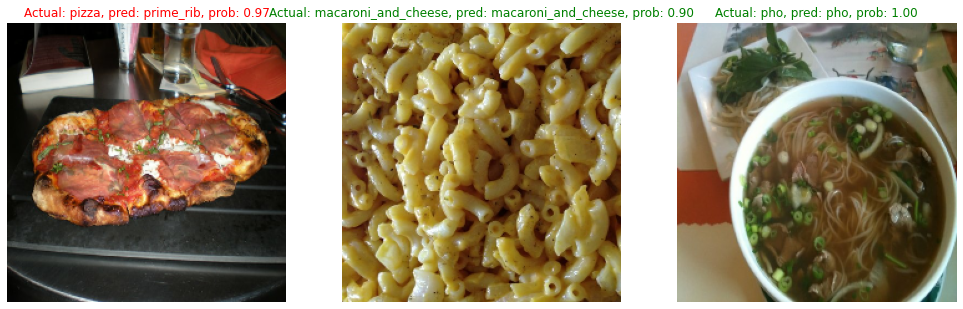

In [57]:
# make preds on as series of random images
import os
import random

plt.figure(figsize = (17,10))
for i in range(3):
  #choose a random image from a random class(es)
  class_name = random.choice(class_names)
  filename= random.choice(os.listdir(test_dir + "/"+ class_name))
  filepath = test_dir + class_name + "/" +filename
  
  #load the image and make predictions
  img = load_and_prep_image(filepath, scale=False)
  pred_prob = model.predict(tf.expand_dims(img,axis=0))
  pred_class = class_names[pred_prob.argmax()] #get highest probability index and match it to class_names
  # print(pred_prob)
  # print(pred_class)

  #plot the images
  plt.subplot(1,3, i+1)
  plt.imshow(img/255.)
  if class_name == pred_class: #if predicted class matches truth class, make text green
    title_color="g"
  else:
    title_color = "r"
  plt.title(f"Actual: {class_name}, pred: {pred_class}, prob: {pred_prob.max():.2f}", c=title_color)
  plt.axis(False);

## Finding the most wrong prediction

write some code to find out the following:
1. Get all of the images file paths in the test dataset using list_files() method
2. Create a pandas DataFrame of the images filepaths, ground truth labels, predicted classes (from our model), max prediction probabilities, prediction class name, ground truth class name.
3. Use our DataFrame to find all the wrong predictions (where the ground truth label doesnt match the predictions)
4. Sort the DataFrame based on wrong predictions (have the highest prediction probability at the top).
5. Visualize the images with the highest prediciton probabilities but have the wrong prediction.

In [58]:
# 1. get all of the images file paths in the test dataset
filepaths = []
for filepath in test_data.list_files("/content/101_food_classes_10_percent/test/*/*.jpg", 
                                      shuffle=False):
  filepaths.append(filepath.numpy)

filepaths[:10]

[<bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=string, numpy=b'/content/101_food_classes_10_percent/test/apple_pie/1011328.jpg'>>,
 <bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=string, numpy=b'/content/101_food_classes_10_percent/test/apple_pie/101251.jpg'>>,
 <bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=string, numpy=b'/content/101_food_classes_10_percent/test/apple_pie/1034399.jpg'>>,
 <bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=string, numpy=b'/content/101_food_classes_10_percent/test/apple_pie/103801.jpg'>>,
 <bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=string, numpy=b'/content/101_food_classes_10_percent/test/apple_pie/1038694.jpg'>>,
 <bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=string, numpy=b'/content/101_food_classes_10_percent/test/apple_pie/1047447.jpg'>>,
 <bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=string, numpy=b

In [59]:
# 2. create a DataFrame of different parameters 
import pandas as pd
pred_df = pd.DataFrame({"img_path": filepaths,
                        "y_true": y_labels,
                        "y_pred": pred_classes,
                        "pred_conf": preds_probs.max(axis=1), #get the maximum prediction probability value
                        "y_true_classname":[class_names[i] for i in y_labels],
                        "y_pred_classname": [class_names[i]for i in pred_classes]})

In [60]:
pred_df

img_path  ...      y_pred_classname
0      <bound method _EagerTensorBase.numpy of <tf.Te...  ...                 gyoza
1      <bound method _EagerTensorBase.numpy of <tf.Te...  ...             apple_pie
2      <bound method _EagerTensorBase.numpy of <tf.Te...  ...             apple_pie
3      <bound method _EagerTensorBase.numpy of <tf.Te...  ...  pulled_pork_sandwich
4      <bound method _EagerTensorBase.numpy of <tf.Te...  ...             prime_rib
...                                                  ...  ...                   ...
25245  <bound method _EagerTensorBase.numpy of <tf.Te...  ...               waffles
25246  <bound method _EagerTensorBase.numpy of <tf.Te...  ...          cheese_plate
25247  <bound method _EagerTensorBase.numpy of <tf.Te...  ...               waffles
25248  <bound method _EagerTensorBase.numpy of <tf.Te...  ...  strawberry_shortcake
25249  <bound method _EagerTensorBase.numpy of <tf.Te...  ...               waffles

[25250 rows x 6 columns]

In [61]:
# 3. find out in our DataFrame which predictions are wrong
pred_df["pred_correct"]= pred_df["y_true"] == pred_df["y_pred"]

In [62]:
pred_df.head()

img_path  ...  pred_correct
0  <bound method _EagerTensorBase.numpy of <tf.Te...  ...         False
1  <bound method _EagerTensorBase.numpy of <tf.Te...  ...          True
2  <bound method _EagerTensorBase.numpy of <tf.Te...  ...          True
3  <bound method _EagerTensorBase.numpy of <tf.Te...  ...         False
4  <bound method _EagerTensorBase.numpy of <tf.Te...  ...         False

[5 rows x 7 columns]

In [63]:
# 4. sort our DataFrame to have most wrong predictions at the top
top_100_wrong = pred_df[pred_df["pred_correct"]==False].sort_values("pred_conf", ascending= False)[:100]

In [64]:
top_100_wrong.head(20)

img_path  ...  pred_correct
21810  <bound method _EagerTensorBase.numpy of <tf.Te...  ...         False
231    <bound method _EagerTensorBase.numpy of <tf.Te...  ...         False
15359  <bound method _EagerTensorBase.numpy of <tf.Te...  ...         False
23539  <bound method _EagerTensorBase.numpy of <tf.Te...  ...         False
21400  <bound method _EagerTensorBase.numpy of <tf.Te...  ...         False
24540  <bound method _EagerTensorBase.numpy of <tf.Te...  ...         False
2511   <bound method _EagerTensorBase.numpy of <tf.Te...  ...         False
5574   <bound method _EagerTensorBase.numpy of <tf.Te...  ...         False
17855  <bound method _EagerTensorBase.numpy of <tf.Te...  ...         False
23797  <bound method _EagerTensorBase.numpy of <tf.Te...  ...         False
18001  <bound method _EagerTensorBase.numpy of <tf.Te...  ...         False
11642  <bound method _EagerTensorBase.numpy of <tf.Te...  ...         False
10847  <bound method _EagerTensorBase.numpy of <tf.Te...  ...         False
23631  <bound method _EagerTensorBase.numpy of <tf.Te...  ...         False
1155   <bound method _EagerTensorBase.numpy of <tf.Te...  ...         False
10854  <bound method _EagerTensorBase.numpy of <tf.Te...  ...         False
23904  <bound method _EagerTensorBase.numpy of <tf.Te...  ...         False
7316   <bound method _EagerTensorBase.numpy of <tf.Te...  ...         False
13144  <bound method _EagerTensorBase.numpy of <tf.Te...  ...         False
10880  <bound method _EagerTensorBase.numpy of <tf.Te...  ...         False

[20 rows x 7 columns]

In [69]:
# 5. Visualize some of the most wrong examples
# images_to_view = 9
# start_index = 10 # change the start index to view more
# plt.figure(figsize=(15, 10))
# for i, row in enumerate(top_100_wrong[start_index:start_index+images_to_view].itertuples()): 
#   plt.subplot(3, 3, i+1)
#   img = load_and_prep_image(row[1], scale=False)
#   _, _, _, _, pred_prob, y_true, y_pred, _ = row # only interested in a few parameters of each row
#   plt.imshow(img/255.)
#   plt.title(f"actual: {y_true}, pred: {y_pred} \nprob: {pred_prob:.2f}")
#   plt.axis(False)


# Test out the big dog model on our own custom images

In [67]:
# get custom images 
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/custom_food_images.zip

--2022-02-27 04:19:32--  https://storage.googleapis.com/ztm_tf_course/food_vision/custom_food_images.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 209.85.146.128, 142.250.148.128, 209.85.200.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|209.85.146.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13192985 (13M) [application/zip]
Saving to: ‘custom_food_images.zip’

custom_food_images. 100%[===================>]  12.58M  35.8MB/s    in 0.4s    

2022-02-27 04:19:33 (35.8 MB/s) - ‘custom_food_images.zip’ saved [13192985/13192985]



In [68]:
unzip_data("custom_food_images.zip")

In [70]:
# get the custom food images filepaths

custom_food_images = ["custom_food_images/" + img_path for img_path in os.listdir("custom_food_images/")]
custom_food_images

['custom_food_images/pizza-dad.jpeg',
 'custom_food_images/hamburger.jpeg',
 'custom_food_images/chicken_wings.jpeg',
 'custom_food_images/steak.jpeg',
 'custom_food_images/sushi.jpeg',
 'custom_food_images/ramen.jpeg']

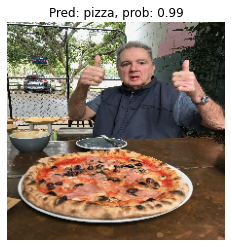

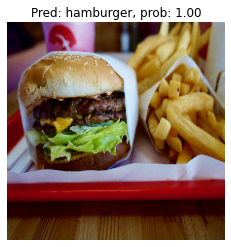

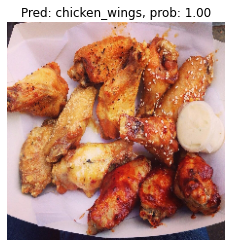

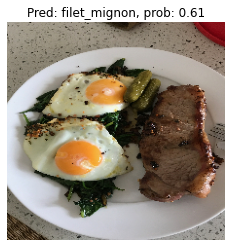

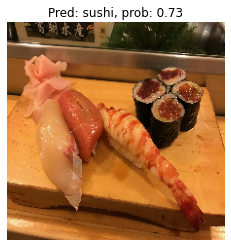

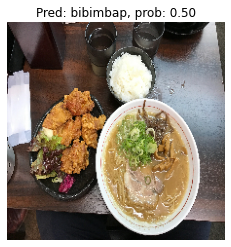

In [73]:
#make prediction on and plot custom food images
for img in custom_food_images:
  img= load_and_prep_image(img, scale = False) # dont need to scale for our EfficientNetB0 model
  pred_prob = model.predict(tf.expand_dims(img, axis=0)) #make prediction on image with shape (1,224,224,3) (same shape as model was trained on)
  pred_class = class_names[pred_prob.argmax()] #get the index with the highest prediction probability

  #plot the appropriate information
  plt.figure()
  plt.imshow(img/255.)
  plt.title(f"Pred: {pred_class}, prob: {pred_prob.max():.2f}")
  plt.axis(False)